In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
df = pd.read_csv(Path('../data/iris.csv'))

In [4]:
df

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [17]:
df_2_class = df[df['class'] != 'Iris-versicolor']

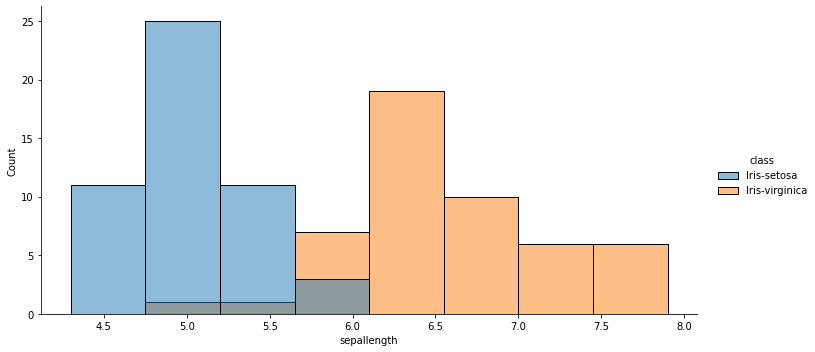

In [18]:
f = sns.displot(data=df_2_class,
x='sepallength',
aspect=2,
hue='class')
f.fig.savefig(Path('./sepal-length-dist.jpg'))

In [24]:
df_2_class['is_setosa'] = df_2_class['class'].map({'Iris-setosa':1, 'Iris-virginica':0})

In [23]:
df_2_class.columns

Index(['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'class',
       'isSetosa'],
      dtype='object')

In [27]:
df_2_class[['sepallength', 'is_setosa']].\
    to_csv(Path('../data/iris-one-feature.csv'),
    header=False,
    sep='|',
    index=False)